In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import math
from sklearn.metrics import mean_squared_error
import networkx as nx
from networkx.algorithms import bipartite

In [265]:
'''
import gzip
import shutil
with gzip.open('all_gene_disease_associations.tsv.gz', 'rb') as f_in:
    with open('all_gene_disease_associations.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
'''

"\nimport gzip\nimport shutil\nwith gzip.open('all_gene_disease_associations.tsv.gz', 'rb') as f_in:\n    with open('all_gene_disease_associations.tsv', 'wb') as f_out:\n        shutil.copyfileobj(f_in, f_out)\n"

In [266]:
data = pd.read_csv('all_gene_disease_associations.tsv', sep='\t')

In [267]:
data

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,1.0,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.700,0.538,C0002736,Amyotrophic Lateral Sclerosis,disease,C18;C10,Disease or Syndrome,0.01,1.0,2008.0,2008.0,1,0,BEFREE
2,1,A1BG,0.700,0.538,C0003578,Apnea,phenotype,C23;C08,Sign or Symptom,0.01,1.0,2017.0,2017.0,1,0,BEFREE
3,1,A1BG,0.700,0.538,C0003864,Arthritis,disease,C05,Disease or Syndrome,0.01,1.0,2019.0,2019.0,1,0,BEFREE
4,1,A1BG,0.700,0.538,C0008373,Cholesteatoma,disease,C17,Disease or Syndrome,0.01,1.0,2020.0,2020.0,1,0,BEFREE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134937,115804232,CEROX1,NaN,NaN,C0005890,Body Height,phenotype,NaN,Organism Attribute,0.10,1.0,2019.0,2019.0,1,0,GWASCAT
1134938,115891964,MIR223HG,0.861,0.077,C0023418,leukemia,disease,C04,Neoplastic Process,0.01,1.0,2016.0,2016.0,1,0,BEFREE
1134939,115891964,MIR223HG,0.861,0.077,C0023467,"Leukemia, Myelocytic, Acute",disease,C04,Neoplastic Process,0.01,1.0,2016.0,2016.0,1,0,BEFREE
1134940,115891964,MIR223HG,0.861,0.077,C0598766,Leukemogenesis,disease,C23;C04,Neoplastic Process,0.01,1.0,2016.0,2016.0,1,0,BEFREE


In [268]:
data.columns

Index(['geneId', 'geneSymbol', 'DSI', 'DPI', 'diseaseId', 'diseaseName',
       'diseaseType', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI',
       'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps', 'source'],
      dtype='object')

In [269]:
data.YearInitial.value_counts().reset_index().sort_values(by="index")

,index,YearInitial
72,1924.0,1
65,1940.0,2
69,1944.0,1
68,1947.0,1
71,1951.0,1
...,...,...
3,2016.0,48870
1,2017.0,107041
2,2018.0,107030
0,2019.0,109693


In [270]:
years = data.YearInitial.value_counts().reset_index().sort_values(by="index")["index"]
count = data.YearInitial.value_counts().reset_index().sort_values(by="index")["YearInitial"]

Text(0.5, 1.0, 'Gene-Disease discoveries by year')

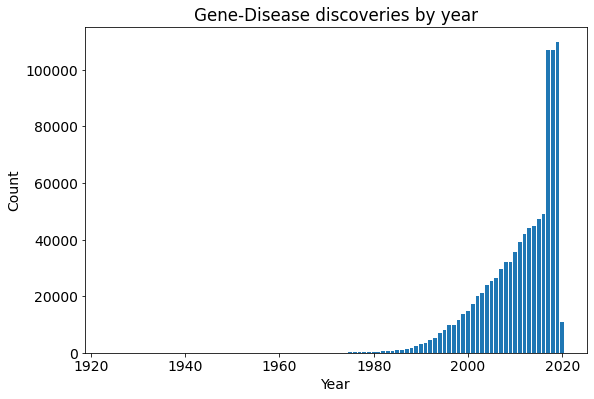

In [271]:
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams.update({'font.size': 14})
plt.bar(years, count)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Gene-Disease discoveries by year")

In [272]:
cummulative_findings_by_years = list(count)
for i in range(1, len(cummulative_findings_by_years)):
    cummulative_findings_by_years[i] += cummulative_findings_by_years[i-1]
cummulative_findings_by_years[-1]

967968

Text(0.5, 1.0, 'Cumulative of Gene-Disease discoveries by year')

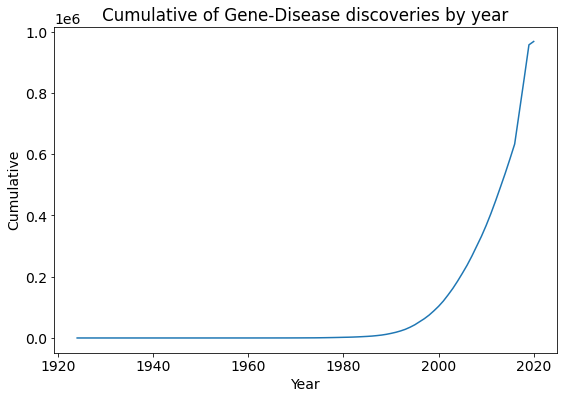

In [273]:
plt.plot(years, cummulative_findings_by_years)
plt.xlabel("Year")
plt.ylabel("Cumulative")
plt.title("Cumulative of Gene-Disease discoveries by year")

In [274]:
#Removing the last year bc clearly the data gathering stopped that year
years = years[:-2]
cummulative_findings_by_years = cummulative_findings_by_years[:-2]

In [275]:
#This doesn't work, it needs scaling on the data
def exponential(x, a, b):
    return a * b **(x-1924)
popt, pcov = curve_fit(exponential, years, cummulative_findings_by_years)
a = popt[0]
b = popt[1]
fitted_exponential = exponential(years, a, b)

In [276]:
#This works
def line(x, a, b):
    return a + b*x
log_cumm = [math.log10(x) for x in cummulative_findings_by_years]
popt, pcov = curve_fit(line, years, log_cumm)
a = popt[0]
b = popt[1]
fitted_line = line(years, a, b)
rmse = mean_squared_error(log_cumm, fitted_line, squared=False)
fitted_line_y = [10**i for i in fitted_line]
a_o = 10**a
b_o = 10**b
lab = "Fitted: log(y) =" + str(round(a,3)) + "+" + str(round(b,3)) + "* x with RMSE = " + str(round(rmse,3))
lab

'Fitted: log(y) =-148.62+0.077* x with RMSE = 0.196'

Text(0.5, 1.0, 'Cumulative of Gene-Disease discoveries by year')

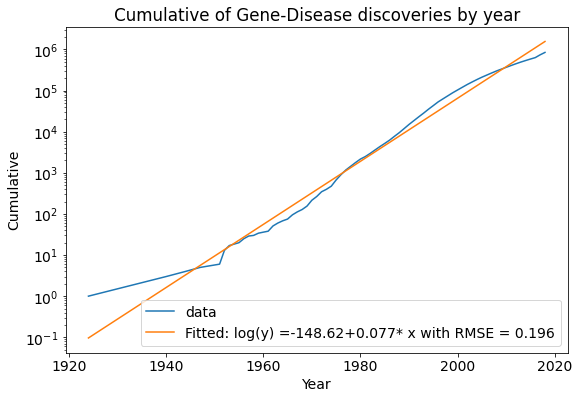

In [277]:
#Exponential try
plt.plot(years, cummulative_findings_by_years, label="data")
plt.plot(years, fitted_line_y, label=lab)
plt.xlabel("Year")
plt.ylabel("Cumulative")
plt.yscale("log")
plt.legend()
plt.title("Cumulative of Gene-Disease discoveries by year")

In [278]:
#Power law try
log_cumm = [math.log10(x) for x in cummulative_findings_by_years]
log_years = [math.log10(x) for x in years]
popt, pcov = curve_fit(line, log_years, log_cumm)
a = popt[0]
b = popt[1]
fitted_line = [line(i, a, b) for i in log_years]
rmse = mean_squared_error(log_cumm, fitted_line, squared=False)
fitted_line_y = [10**i for i in fitted_line]
a_o = 10**a
b_o = 10**b
lab = "Fitted: log(y) =" + str(round(a,3)) + "+" + str(round(b,3)) + "* log(x) with RMSE = " + str(round(rmse,3))
lab

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


'Fitted: log(y) =-1149.148+349.577* log(x) with RMSE = 0.199'

Text(0.5, 1.0, 'Cumulative of Gene-Disease discoveries by year')

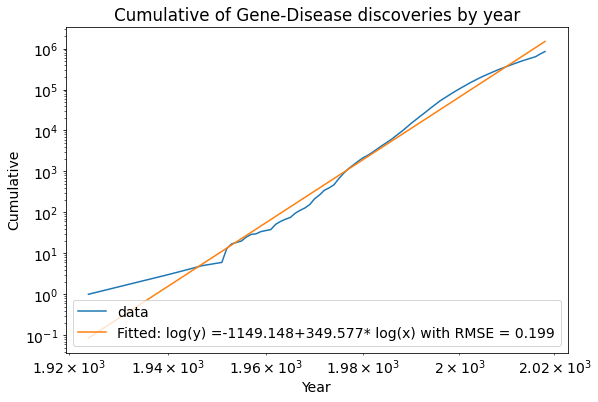

In [279]:
plt.plot(years, cummulative_findings_by_years, label="data")
plt.plot(years, fitted_line_y, label=lab)
plt.xlabel("Year")
plt.ylabel("Cumulative")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("Cumulative of Gene-Disease discoveries by year")

In [280]:
data["source"].value_counts().reset_index().sort_values(by="source",ascending=False)[5:].source.sum()

103540

In [281]:
data["source"].value_counts().reset_index().sort_values(by="source",ascending=False)[:5]

,index,source
0,BEFREE,789377
1,HPO,148643
2,CTD_human,44786
3,GWASCAT,34270
4,CLINVAR,14326


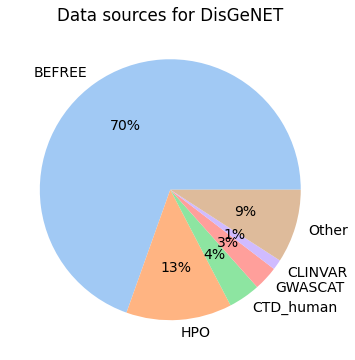

In [282]:
#define data
data_pie = list(data["source"].value_counts().reset_index().sort_values(by="source",ascending=False)["source"][:5])
labels = list(data["source"].value_counts().reset_index().sort_values(by="source",ascending=False)["index"][:5])
data_pie.append(103540)
labels.append("Other")
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:6]

#create pie chart
plt.pie(data_pie, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Data sources for DisGeNET")
plt.show()

In [283]:
network = data[["geneSymbol","diseaseId", "diseaseName"]]
network

,geneSymbol,diseaseId,diseaseName
0,A1BG,C0001418,Adenocarcinoma
1,A1BG,C0002736,Amyotrophic Lateral Sclerosis
2,A1BG,C0003578,Apnea
3,A1BG,C0003864,Arthritis
4,A1BG,C0008373,Cholesteatoma
...,...,...,...
1134937,CEROX1,C0005890,Body Height
1134938,MIR223HG,C0023418,leukemia
1134939,MIR223HG,C0023467,"Leukemia, Myelocytic, Acute"
1134940,MIR223HG,C0598766,Leukemogenesis


In [284]:
data.columns

Index(['geneId', 'geneSymbol', 'DSI', 'DPI', 'diseaseId', 'diseaseName',
       'diseaseType', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI',
       'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps', 'source'],
      dtype='object')

In [285]:
diseases_ids = list(network["diseaseId"].unique())
len(diseases_ids)

30170

In [286]:
diseases = list(network["diseaseName"].unique())
len(diseases)

30170

In [287]:
genes = list(network["geneSymbol"].unique())
len(genes)

21666

In [288]:
edges = []
for i in network.index:
    edges.append((network["geneSymbol"][i], network["diseaseName"][i]))

In [289]:
edges[0]

('A1BG', 'Adenocarcinoma')

In [290]:
len(edges)

1134942

In [291]:
G = nx.Graph()
G.add_nodes_from(genes,bipartite=0)
G.add_nodes_from(diseases,bipartite=1)
G.add_edges_from(edges)
top = [node for node in G.nodes() if G.nodes[node]['bipartite']==0]
bottom = [node for node in G.nodes() if G.nodes[node]['bipartite']==1]

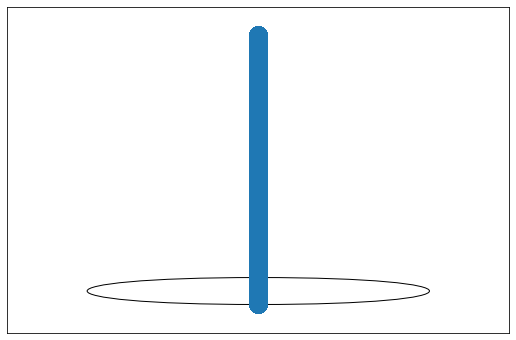

In [295]:
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(top) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(bottom) ) # put nodes from Y at x=2
nx.draw_networkx(G, pos=pos, with_labels = False)
plt.show()

In [319]:
all_nodes = []
for i in diseases:
    all_nodes.append((i,G.degree(i),"disease"))
for i in genes:
    all_nodes.append((i,G.degree(i),"gene"))
all_nodes
df_ntw = pd.DataFrame(all_nodes, columns =['Node', 'Degree','Type'])
df_ntw

,Node,Degree,Type
0,Adenocarcinoma,2235,disease
1,Amyotrophic Lateral Sclerosis,1114,disease
2,Apnea,262,disease
3,Arthritis,1072,disease
4,Cholesteatoma,135,disease
...,...,...,...
51831,H3P33,19,gene
51832,H3P40,175,gene
51833,LNC-LBCS,3,gene
51834,CEROX1,1,gene


In [320]:
df_ntw.to_csv("nodes.csv")

In [380]:
aux1 = [i[0] for i in edges]
aux2 = [i[1] for i in edges]
df_edges = pd.DataFrame(list(zip(aux1, aux2)),columns =['Source', 'Target'])
df_edges

,Source,Target
0,A1BG,Adenocarcinoma
1,A1BG,Amyotrophic Lateral Sclerosis
2,A1BG,Apnea
3,A1BG,Arthritis
4,A1BG,Cholesteatoma
...,...,...
1134937,CEROX1,Body Height
1134938,MIR223HG,leukemia
1134939,MIR223HG,"Leukemia, Myelocytic, Acute"
1134940,MIR223HG,Leukemogenesis


In [381]:
df_edges.to_csv("edges.csv")

In [382]:
df_ntw[df_ntw["Type"]=="gene"].sort_values(by="Degree", ascending=False)

,Node,Degree,Type
35359,TNF,2724,gene
35385,TP53,2494,gene
32743,IL6,2367,gene
35577,VEGFA,1899,gene
32729,IL1B,1801,gene
...,...,...,...
48557,DEFB108C,1,gene
45049,FBXO27,1,gene
39011,H2AP,1,gene
48555,DPRX,1,gene


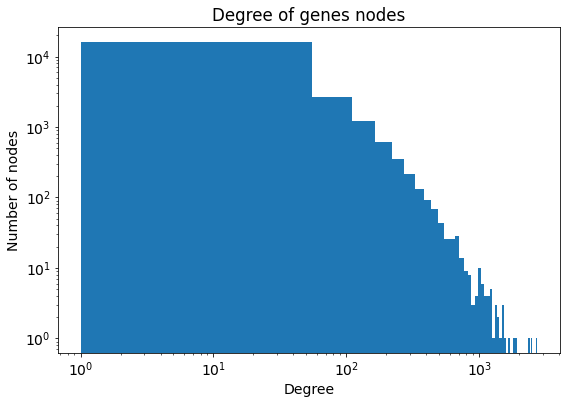

In [371]:
gene_degree = df_ntw[df_ntw["Type"]=="gene"].sort_values(by="Degree", ascending=False).Degree
plt.hist(gene_degree, bins=50);
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree of genes nodes")
plt.xscale("log")
plt.yscale("log")

In [334]:
df_ntw[df_ntw["Type"]=="disease"].sort_values(by="Degree", ascending=False)

,Node,Degree,Type
75,Neoplasms,10161,disease
37,Malignant Neoplasms,8621,disease
145,Primary malignant neoplasm,8221,disease
172,Malignant neoplasm of breast,6940,disease
241,Breast Carcinoma,6775,disease
...,...,...,...
23239,Bilateral facial muscle weakness,1,disease
23240,EPIDERMOLYSIS BULLOSA SIMPLEX WITH NAIL DYSTROPHY,1,disease
23241,Axial muscle atrophy,1,disease
23242,Membranous conjunctivitis,1,disease


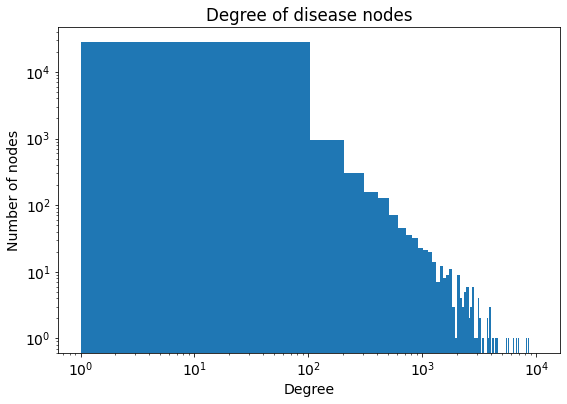

In [379]:
gene_degree = df_ntw[df_ntw["Type"]=="disease"].sort_values(by="Degree", ascending=False).Degree
plt.hist(gene_degree, bins=100);
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree of disease nodes")
plt.xscale("log")
plt.yscale("log")

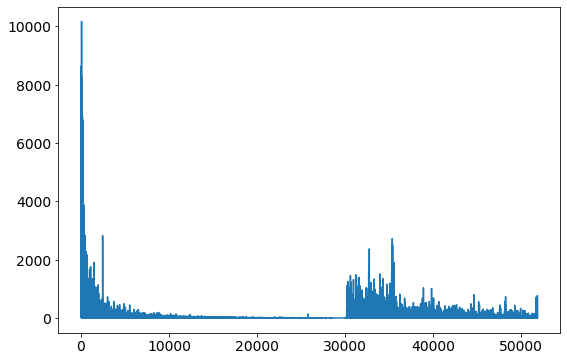

In [330]:
plt.plot(df_ntw.Degree)

In [460]:
top_N = 200

In [461]:
top_50_diseases = list(df_ntw[df_ntw["Type"]=="disease"].sort_values(by="Degree", ascending=False)[300:300+top_N].Node)

In [462]:
top_50_genes = list(df_ntw[df_ntw["Type"]=="gene"].sort_values(by="Degree", ascending=False)[300:300+top_N].Node)

In [463]:
import random as r
aux1 = []
aux2 = []
for i in range(20):
    aux1.append(top_50_diseases[r.randint(0,top_N)])
    aux2.append(top_50_genes[r.randint(0,top_N)])
top_50_diseases = aux1
top_50_genes = aux2

In [464]:
edges[0]

('A1BG', 'Adenocarcinoma')

In [465]:
top_50_edges = []
for i in top_50_genes:
    for j in edges:
        if j[0] == i and j[1] in top_50_diseases:
            top_50_edges.append(j)

In [466]:
len(top_50_edges)

72

In [467]:
top_50_edges[0]

('LOX', 'Dermatologic disorders')

In [468]:
df_top_50 = pd.DataFrame(top_50_edges, columns =['Source', 'Target'])

In [469]:
df_top_50.to_csv("top_50.csv")

In [471]:
top_50_nodes = []
for i in top_50_diseases:
    top_50_nodes.append((i,"disease"))
for i in top_50_genes:
    top_50_nodes.append((i,"gene"))
aux_df = pd.DataFrame(top_50_nodes, columns =['Node','Type'])
aux_df.to_csv("top_50_nodes.csv")

In [456]:
top_50_nodes = top_50_diseases + top_50_genes

In [457]:
df = pd.DataFrame(top_50_nodes)

In [458]:
df

,0
0,Oestrogen receptor positive breast cancer
1,"Mammary Carcinoma, Human"
2,Triglycerides measurement
3,Post-Traumatic Stress Disorder
4,Metastatic melanoma
5,Orbital separation excessive
6,Byzanthine arch palate
7,Gallbladder Carcinoma
8,Helicobacter pylori (H. pylori) infection in c...
9,Adenocarcinoma of pancreas


In [459]:
#df.to_csv("top_50_nodes.csv")

In [485]:
top_50_diseases = df_ntw[df_ntw["Type"]=="gene"].sort_values(by="Degree", ascending=False).head(25)

In [486]:
top_50_diseases

,Node,Degree,Type
35359,TNF,2724,gene
35385,TP53,2494,gene
32743,IL6,2367,gene
35577,VEGFA,1899,gene
32729,IL1B,1801,gene
32753,IL10,1679,gene
35285,TGFB1,1558,gene
32674,IFNG,1519,gene
33956,PIK3CA,1511,gene
31202,CRP,1483,gene


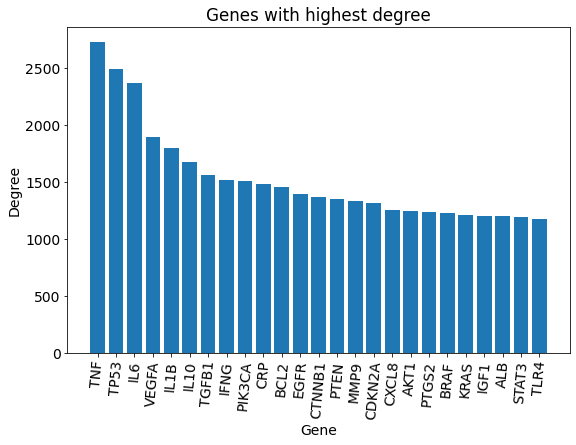

In [489]:
plt.bar(top_50_diseases.Node,top_50_diseases.Degree)
plt.xlabel("Gene")
plt.ylabel("Degree")
plt.title("Genes with highest degree")
plt.xticks(rotation='85');

In [490]:
B = bipartite.projected_graph(G, bottom)

In [499]:
all_nodes = []
for i in diseases:
    all_nodes.append((i,B.degree(i),"disease"))
all_nodes
df_ntw = pd.DataFrame(all_nodes, columns =['Node', 'Degree','Type'])
highest_diseases = list(df_ntw.sort_values(by="Degree", ascending=False).head(10).Node)

In [504]:
l = list(B.edges(highest_diseases))

In [508]:
aux_F = []
for i in l:
    if i[1] in highest_diseases:
        aux_F.append(i)

In [509]:
aux_F

[('Neoplasms', 'Liver carcinoma'),
 ('Neoplasms', 'Malignant Neoplasms'),
 ('Neoplasms', 'Neoplasm Metastasis'),
 ('Neoplasms', 'Breast Carcinoma'),
 ('Neoplasms', 'Primary malignant neoplasm'),
 ('Neoplasms', 'Malignant neoplasm of breast'),
 ('Neoplasms', 'Tumor Cell Invasion'),
 ('Neoplasms', 'Carcinogenesis'),
 ('Neoplasms', 'Colorectal Carcinoma'),
 ('Malignant Neoplasms', 'Liver carcinoma'),
 ('Malignant Neoplasms', 'Breast Carcinoma'),
 ('Malignant Neoplasms', 'Primary malignant neoplasm'),
 ('Malignant Neoplasms', 'Malignant neoplasm of breast'),
 ('Malignant Neoplasms', 'Tumor Cell Invasion'),
 ('Malignant Neoplasms', 'Carcinogenesis'),
 ('Malignant Neoplasms', 'Colorectal Carcinoma'),
 ('Malignant Neoplasms', 'Neoplasm Metastasis'),
 ('Primary malignant neoplasm', 'Liver carcinoma'),
 ('Primary malignant neoplasm', 'Neoplasm Metastasis'),
 ('Primary malignant neoplasm', 'Tumor Cell Invasion'),
 ('Primary malignant neoplasm', 'Breast Carcinoma'),
 ('Primary malignant neoplasm'

In [510]:
uni = pd.DataFrame(aux_F, columns =['Source','Target'])
uni.to_csv("unipart.csv")